In [ ]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark

In [ ]:
!pip install pyspark

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pyspark
from pyspark import SparkContext
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import cv2
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from keras.applications.vgg16 import VGG16

In [ ]:
gen_params = {"rescale":1.0/255,
              "featurewise_center":False,
              "samplewise_center":False,
              "featurewise_std_normalization":False,
              "samplewise_std_normalization":False,
              "zca_whitening":False,
              "rotation_range":20,
              "width_shift_range":0.1,
              "height_shift_range":0.1,
              "shear_range":0.2,
              "zoom_range":0.1,
              "horizontal_flip":True,
              "fill_mode":'constant',
              "cval": 0,
              "validation_split":0.15}

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**gen_params)

test_params = {"rescale":1.0/255,}
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**test_params)


## Data generator for training images
train_generator = train_datagen.flow_from_directory('car_data/car_data/train',
                                                    class_mode='categorical', batch_size = 32,
                                                    target_size=(224,224),color_mode='rgb',shuffle = True,subset='training')

val_generator = train_datagen.flow_from_directory('car_data/car_data/train',
                                                    class_mode='categorical', batch_size = 32, 
                                                    target_size=(224,224),color_mode='rgb',shuffle = True,subset='validation')

test_generator = test_datagen.flow_from_directory('car_data/car_data/test',
                                                    class_mode='categorical', batch_size = 32,
                                                    target_size=(224,224),color_mode='rgb',shuffle = True)

Found 7018 images belonging to 196 classes.
Found 1126 images belonging to 196 classes.
Found 8041 images belonging to 196 classes.


In [ ]:
list_data = [train_generator.samples,
             val_generator.samples,
             test_generator.samples,
             train_generator.samples+val_generator.samples+test_generator.samples,
             train_generator.image_shape,
             len(np.unique(train_generator.classes))]

df = pd.DataFrame([list_data],
                  columns=['Number of training images','Number of validation images','Number of testing images','Total number of images','Size of each image','Number of Classes'],
                  index=['Value']).transpose()

display(df)

,Value
Number of training images,7018
Number of validation images,1126
Number of testing images,8041
Total number of images,16185
Size of each image,"(224, 224, 3)"
Number of Classes,196


In [ ]:
from collections import Counter
train = Counter(train_generator.classes)
val = Counter(val_generator.classes)
test = Counter(test_generator.classes)
total = dict(train+val+test)
class_names = dict(train_generator.class_indices)
class_names = {v: k for k, v in class_names.items()}

In [ ]:
class_df = pd.DataFrame([class_names,total]).transpose()
class_df.columns=['Marka','Resim Sayısı']
class_df

,Marka,Resim Sayısı
0,AM General Hummer SUV 2000,89
1,Acura Integra Type R 2001,89
2,Acura RL Sedan 2012,64
3,Acura TL Sedan 2012,86
4,Acura TL Type-S 2008,84
...,...,...
191,Volkswagen Golf Hatchback 2012,86
192,Volvo 240 Sedan 1993,91
193,Volvo C30 Hatchback 2012,83
194,Volvo XC90 SUV 2007,86


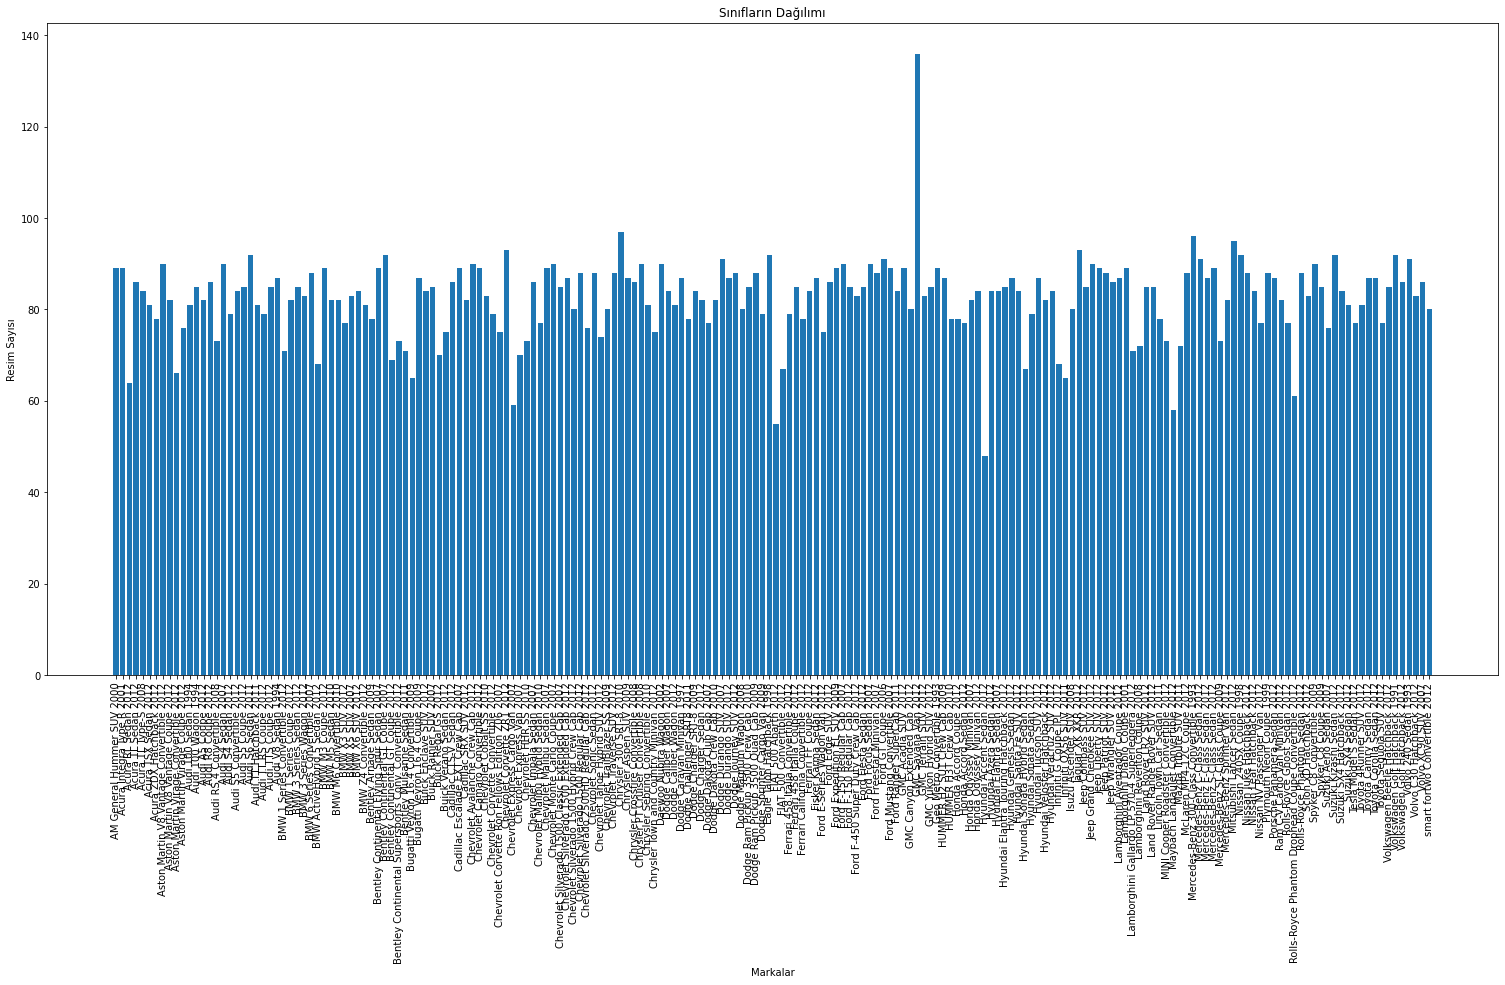

In [ ]:
fig = plt.figure()
fig.set_size_inches(26,12)
plt.bar(class_df['Marka'],class_df['Resim Sayısı'])
plt.xticks(rotation=90)
plt.xlabel("Markalar")
plt.ylabel("Resim Sayısı")
plt.title("Sınıfların Dağılımı")
plt.show()

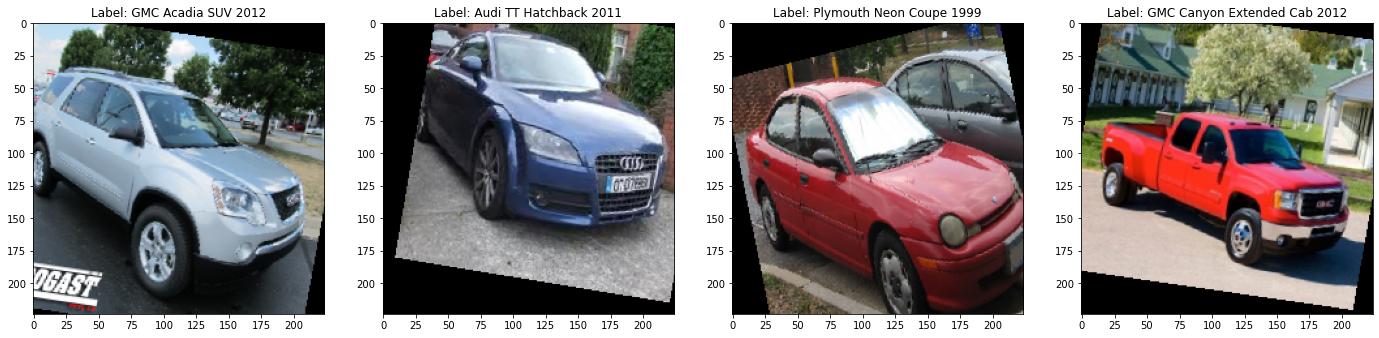

In [ ]:
plt.figure(figsize = (24,18))
Xbatch,Ybatch = train_generator.__getitem__(0)
for ii in range(4):
    plt.subplot(1,4,ii+1)
    plt.imshow((Xbatch[ii]- Xbatch[ii].min())/(Xbatch.max() - Xbatch[ii].min()), cmap = "gray")
    plt.title("Label: %s" %class_names[int(Ybatch[ii].argmax())])
plt.show()

In [ ]:
def build_vgg16_transfer_learning_model(img_height=224,img_width=224,num_classes=196):

    # base model
    base_model = tf.keras.applications.VGG16(
        weights='imagenet',
        input_shape=(img_height, img_width, 3),
        include_top=False) 
    base_model.trainable = False

    # add the top
    input_image = tf.keras.Input(shape=(img_height, img_width, 3))
    x1 = base_model(input_image, training=False)
    x2 = tf.keras.layers.Flatten()(x1)
    out = tf.keras.layers.Dense(num_classes,activation = 'softmax')(x2)
    model = tf.keras.Model(inputs = input_image, outputs =out)
  
    #compile and return
    model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-4),loss='categorical_crossentropy',metrics=['accuracy'])
    
    return model

In [ ]:
model = build_vgg16_transfer_learning_model()
model.summary()

58900480/58889256 [==============================] - 20s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 196)               4917444   
                                                                 
Total params: 19,632,132
Trainable params: 4,917,444
Non-trainable params: 14,714,688
_________________________________________________________________


C:\Users\Hiddenslate\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model_name = "vgg_car_classification.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%4 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [ ]:
batch = 32
num_epochs = 50

history = model.fit(train_generator,
                    validation_data = val_generator,
                    epochs=num_epochs,
                    verbose=1,
                    batch_size=batch,
                    callbacks=[early_stop,monitor,lr_schedule])